In [64]:
import pandas as pd
from sklearn import svm

path = 'datasets/drug_consumption_engineered.csv'
dataset_D = pd.read_csv(path)

dataset_D.head()

,ID,Age,Gender,Education,Countery,Ethnicity,NScore,EScore,OScore,AScore,...,Cannabis,Cannabis_Consume,Choc,Choc_Consume,Ecstasy,Ecstasy_Consume,Nicotine,Nicotine_Consume,VSA,VSA_Consume
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,0,CL5,1,CL0,0,CL2,1,CL0,0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,1,CL6,1,CL4,1,CL4,1,CL0,0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL3,1,CL4,1,CL0,0,CL0,0,CL0,0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL2,1,CL4,1,CL0,0,CL2,1,CL0,0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL3,1,CL6,1,CL1,0,CL2,1,CL0,0


In [65]:

selected_feature_columns = ['Age', 'Countery', 'SS']
selected_feature = dataset_D.loc[:, selected_feature_columns]
selected_feature.head()

,Age,Countery,SS
0,0.49788,0.96082,-1.18084
1,-0.07854,0.96082,-0.21575
2,0.49788,0.96082,0.40148
3,-0.95197,0.96082,-1.18084
4,0.49788,0.96082,-0.21575


In [66]:
selected_target = dataset_D.Cannabis_Consume
selected_target.head()

0    0
1    1
2    1
3    1
4    1
Name: Cannabis_Consume, dtype: int64

In [67]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import preprocessing

db1_kfold = dataset_D.copy(deep=True)
selected_feature = db1_kfold.loc[:, selected_feature_columns]
selected_target = db1_kfold.Cannabis_Consume

preprocessing.MinMaxScaler()
selected_feature = preprocessing.MinMaxScaler().fit_transform(selected_feature)

from sklearn import tree 
dt_classifer_os = tree.DecisionTreeClassifier(min_samples_split=5, splitter="best", min_samples_leaf=50, criterion="gini", min_weight_fraction_leaf=0.1, min_impurity_decrease=0.01)

k_fold_cv_os = KFold(n_splits=10)
smote_os = SMOTE()

dt_scores_os_recall = []
dt_scores_os_precison = []
results_os = pd.DataFrame()

for train_index, test_index in k_fold_cv_os.split(selected_feature, selected_target):
    train_selected_feature_fold, train_selected_target_fold = selected_feature[train_index], selected_target[train_index]
    test_selected_feature_fold, test_selected_target_fold = selected_feature[test_index], selected_target[test_index]

    train_selected_feature_os, train_selected_target_os = smote_os.fit_resample(train_selected_feature_fold, train_selected_target_fold)

    dt_model_os = dt_classifer_os.fit(train_selected_feature_os, train_selected_target_os)
    
    dt_scores_os_recall.append(metrics.recall_score(test_selected_target_fold, dt_model_os.predict(test_selected_feature_fold)))
    dt_scores_os_precison.append(metrics.precision_score(test_selected_target_fold, dt_model_os.predict(test_selected_feature_fold)))

results_os["dt_scores_os_recall"] = dt_scores_os_recall
results_os["dt_scores_os_precison"] = dt_scores_os_precison


In [68]:
from sklearn.tree import export_text

decision_text = export_text(dt_classifer_os, feature_names=selected_feature_columns)

print(decision_text)

|--- Countery <= 0.51
|   |--- class: 1
|--- Countery >  0.51
|   |--- SS <= 0.54
|   |   |--- Age <= 0.41
|   |   |   |--- class: 0
|   |   |--- Age >  0.41
|   |   |   |--- class: 0
|   |--- SS >  0.54
|   |   |--- class: 1



[Text(0.4, 0.875, 'Countery <= 0.512\ngini = 0.5\nsamples = 2242\nvalue = [1121, 1121]'),
 Text(0.2, 0.625, 'gini = 0.272\nsamples = 696\nvalue = [113, 583]'),
 Text(0.6, 0.625, 'SS <= 0.537\ngini = 0.454\nsamples = 1546\nvalue = [1008, 538]'),
 Text(0.4, 0.375, 'Age <= 0.413\ngini = 0.347\nsamples = 1009\nvalue = [784, 225]'),
 Text(0.2, 0.125, 'gini = 0.439\nsamples = 609\nvalue = [411, 198]'),
 Text(0.6, 0.125, 'gini = 0.126\nsamples = 400\nvalue = [373, 27]'),
 Text(0.8, 0.375, 'gini = 0.486\nsamples = 537\nvalue = [224, 313]')]

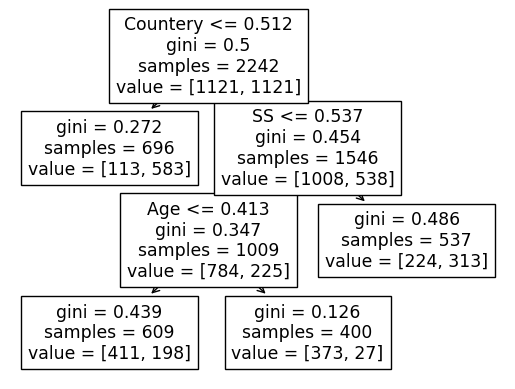

In [69]:
from sklearn import tree

tree.plot_tree(dt_classifer_os, feature_names=selected_feature_columns)

0.7261787272508667
0.8194892933704392


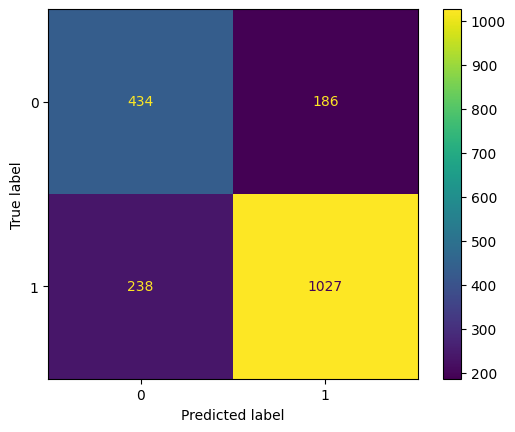

In [70]:
from sklearn import metrics

print(results_os["dt_scores_os_recall"].mean())
print(results_os["dt_scores_os_precison"].mean())
metrics.ConfusionMatrixDisplay.from_estimator(dt_classifer_os, selected_feature, selected_target)
